## Imports

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import GridSearchCV
import shap

c:\Users\ggarcia\OneDrive - Abonmarche\Documents\GitHub\LSLPredictiveModeling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Wrangling

In [ ]:
# Load encoded data
training_data = pd.read_csv('CSV/InitialKnowns.csv')
training_data.head()

In [3]:
# Drop columns that are not needed
training_data = training_data.drop(columns=['Utility Side Material', 'Utility Side Basis of Material Classification', 'Utility Status', 'Customer SIde Material', 'Customer Side Basis of Material Classification', 'Customer Status', 'Building Style', 'ZipCode', 'Building Condition', 'Census Tract', 'Fire District', 'Voting District', 'Zoning', 'CityCouncilDistrict', 'INLeadRiskCategory'])

In [4]:
# Rename columns
training_data = training_data.rename(columns={'Facility ID (External Asset ID)': 'FACILITYID', 'Year Structure Built': 'YEARSTRUCTUREBUILT', 'Year of Water Main Install': 'YEAROFWATERMAININSTALL', 'Effective Year': 'EFFECTIVEYEAR'})

<Axes: >

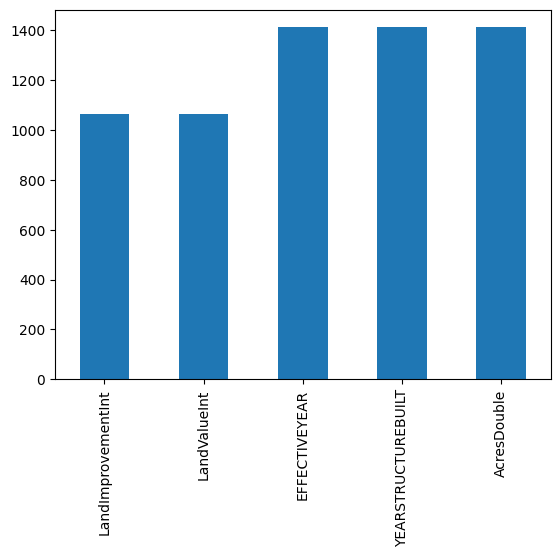

In [5]:
# list numeric columns with missing values
# Filter numeric columns
numeric_cols = training_data.select_dtypes(include=[np.number])

# Find missing values in numeric columns
missing = numeric_cols.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()


In [6]:
# for each numeric column with values missing fill in missing values with the median value of the column
filled_values_info = []

for col in numeric_cols.columns:
    missing = training_data[col].isnull()
    num_missing = np.sum(missing)

    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        median_val = training_data[col].median()
        training_data[col] = training_data[col].fillna(median_val)
        filled_values_info.append((col, num_missing, median_val))

# Print the information about filled values
for col, num_missing, median_val in filled_values_info:
    print(f"Column '{col}': filled {num_missing} missing values with median value {median_val}")

Column 'YEARSTRUCTUREBUILT': filled 1413 missing values with median value 1990.0
Column 'EFFECTIVEYEAR': filled 1413 missing values with median value 2001.0
Column 'LandValueInt': filled 1065 missing values with median value 52700.0
Column 'LandImprovementInt': filled 1065 missing values with median value 266950.0
Column 'AcresDouble': filled 1413 missing values with median value 0.257


In [8]:
# save to csv
training_data.to_csv('CSV/InitialTrainingCleaned.csv', index=False)

## Create Model

In [9]:
# Define X (features) and y (target variable)
X = training_data.drop(columns=['FACILITYID', 'LeadPrediction'])
y = training_data['LeadPrediction']

# Create a stratified shuffle split object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Split the data
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Optionally, print the class distribution to verify
print(f"Train set lead ratio: {sum(y_train)/len(y_train):.4f}")
print(f"Test set lead ratio: {sum(y_test)/len(y_test):.4f}")

Train set lead ratio: 0.0442
Test set lead ratio: 0.0444


In [10]:
# Calculate scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Define parameters
params = {
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': scale_pos_weight
}

In [11]:
# Set up the XGBoost classifier with the current parameters
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, objective='binary:logistic')

# Define hyperparameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 7],
    'eta': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
}

# Perform grid search with cross-validation (5-fold)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best parameters found: ", grid_search.best_params_)
print("Best AUC score: ", grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters found:  {'colsample_bytree': 0.6, 'eta': 0.1, 'max_depth': 5, 'subsample': 1.0}
Best AUC score:  0.9703085889702934


In [12]:
# Set the best hyperparameters found by GridSearchCV
final_model = xgb.XGBClassifier(
    colsample_bytree=0.6,  # Best found value
    eta=0.1,               # Best found value
    max_depth=5,           # Best found value
    subsample=1.0,         # Best found value
    scale_pos_weight=scale_pos_weight,  # Keep scale_pos_weight to handle class imbalance
    objective='binary:logistic',        # Binary classification objective
    # use_label_encoder=False,            # To avoid XGBoost warnings with scikit-learn 1.0+
    eval_metric='logloss'               # Evaluation metric during training
)

In [13]:
# Train the final model
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.1, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [14]:
# Predict probabilities for the positive class (lead = 1) for the test set
y_pred_prob = final_model.predict_proba(X_test)[:, 1]

In [15]:
# Convert probabilities to binary class labels using a threshold of 0.9
y_pred_binary = (y_pred_prob > 0.9).astype(int)

In [16]:
# Print classification report (Precision, Recall, F1-score, Accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

# Calculate and print AUC-ROC score
auc_roc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC-ROC: {auc_roc:.4f}")

# Optionally, calculate and print additional evaluation metrics
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2260
           1       0.58      0.57      0.57       105

    accuracy                           0.96      2365
   macro avg       0.78      0.78      0.78      2365
weighted avg       0.96      0.96      0.96      2365

Confusion Matrix:
[[2216   44]
 [  45   60]]
AUC-ROC: 0.9754
Precision: 0.5769
Recall: 0.5714
F1 Score: 0.5742


In [17]:
# Calculate accuracy using binary predictions (0 or 1)
accuracy = accuracy_score(y_test, y_pred_binary)

# Calculate ROC-AUC score using the predicted probabilities for the positive class (lead = 1)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

Accuracy: 0.9624
ROC-AUC Score: 0.9754


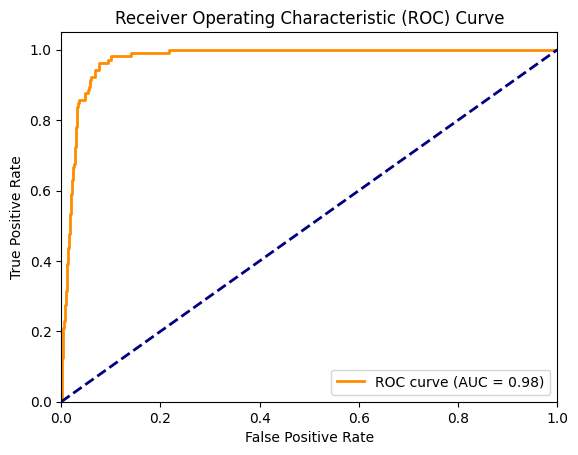

In [18]:
# plot the curve
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Dashed diagonal line for random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

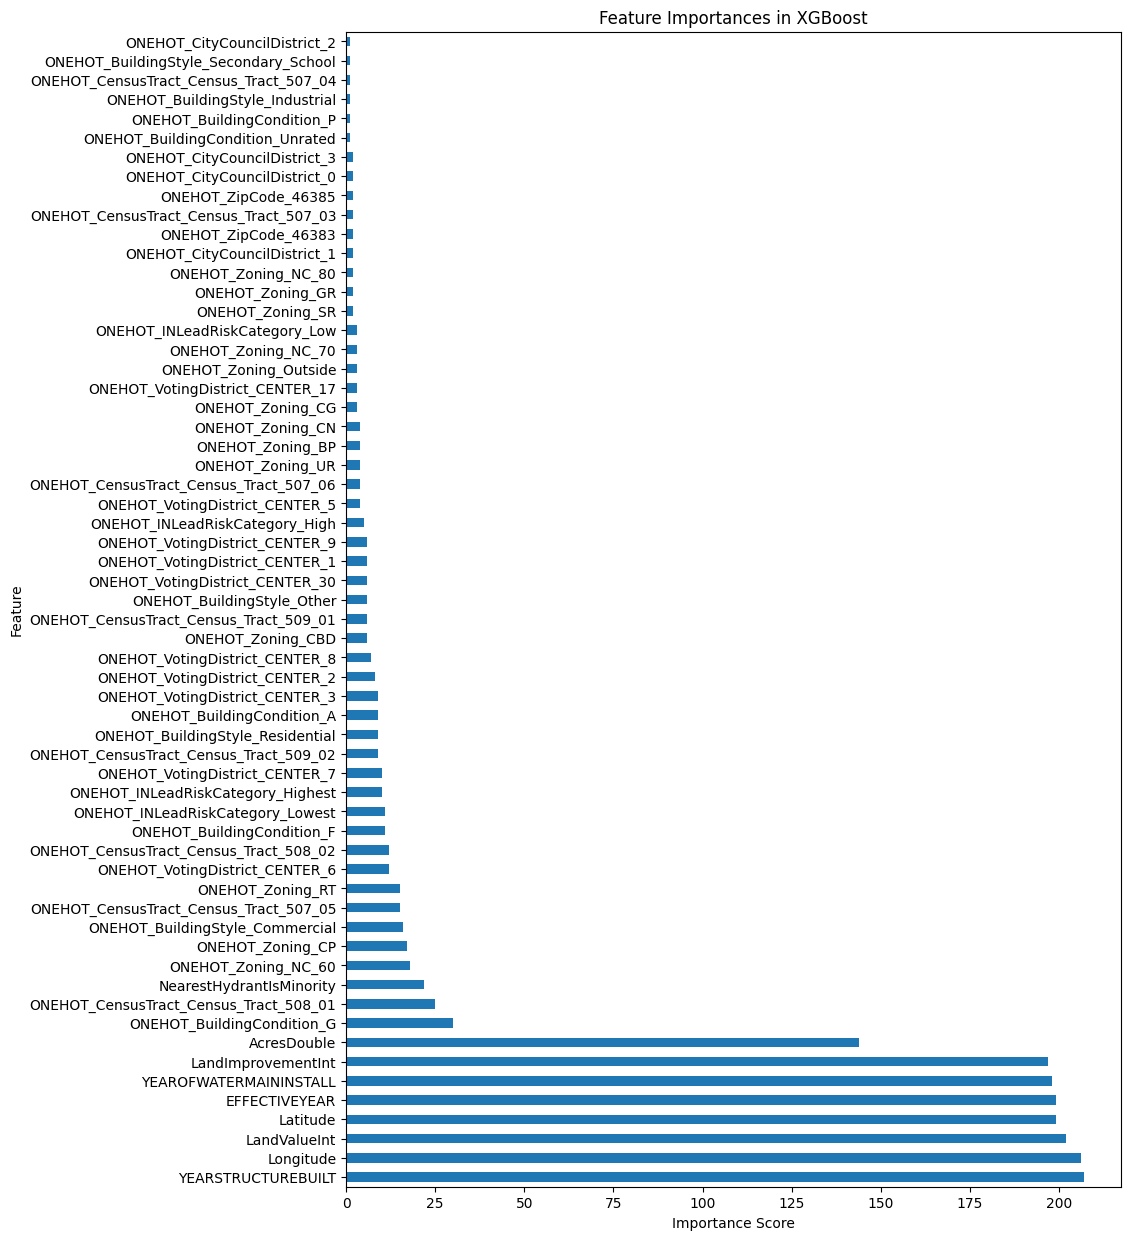

In [19]:
# Get feature importances from the current model
feature_importance = final_model.get_booster().get_score(importance_type='weight')

# Convert the feature importances to a pandas series, sorted by importance
feature_importance_series = pd.Series(feature_importance).sort_values(ascending=False)

# Plot the non-zero feature importances using a horizontal bar chart
plt.figure(figsize=(10, 15))
feature_importance_series.plot(kind='barh')
plt.title('Feature Importances in XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

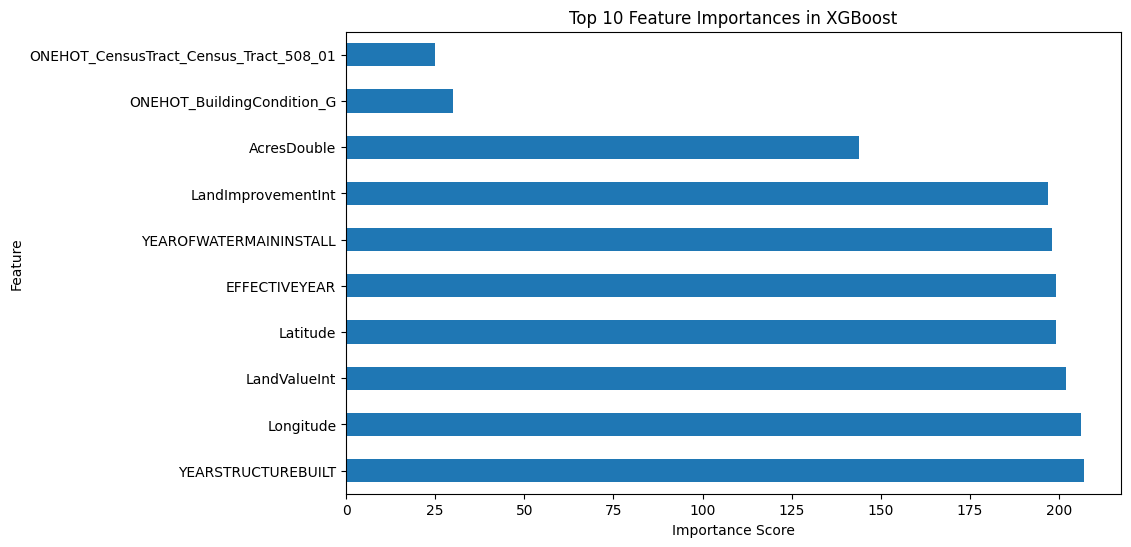

In [20]:
# Only plot top 10 features
# Get feature importances from the current model
feature_importance = final_model.get_booster().get_score(importance_type='weight')

# Convert the feature importances to a pandas series, sorted by importance
feature_importance_series = pd.Series(feature_importance).sort_values(ascending=False)

# Limit to the top 10 features
top_10_features = feature_importance_series.head(10)

# Plot the top 10 features using a horizontal bar chart
plt.figure(figsize=(10, 6))
top_10_features.plot(kind='barh')
plt.title('Top 10 Feature Importances in XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

## Predict

### Wrangle Data

In [ ]:
# Load encoded data
prediction_data = pd.read_csv('CSV/All_Points_For_Initial_Prediction.csv')
prediction_data.head()

In [22]:
# Drop columns that are not needed
prediction_data = prediction_data.drop(columns=['Utility Side Material', 'Utility Side Basis of Material Classification', 'Utility Status', 'Customer SIde Material', 'Customer Side Basis of Material Classification', 'Customer Status', 'Building Style', 'ZipCode', 'Building Condition', 'Census Tract', 'Fire District', 'Voting District', 'Zoning', 'CityCouncilDistrict', 'INLeadRiskCategory'])

In [23]:
# Rename columns
# Facility ID (External Asset ID) to FACILITYID
# Year Structure Built to YEARSTRUCTUREBUILT
# Year of Water Main Install to YEAROFWATERMAININSTALL
# Effective Year to EFFECTIVEYEAR
# Lead Prediction to KnownLeadBinary
prediction_data = prediction_data.rename(columns={'Facility ID (External Asset ID)': 'FACILITYID', 'Year Structure Built': 'YEARSTRUCTUREBUILT', 'Year of Water Main Install': 'YEAROFWATERMAININSTALL', 'Effective Year': 'EFFECTIVEYEAR', 'LeadPrediction': 'KnownLeadBinary'})

In [24]:
# list numeric columns with missing values
# Filter numeric columns
numeric_cols = prediction_data.select_dtypes(include=[np.number])

# Find missing values in numeric columns
missing = numeric_cols.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
# missing.plot.bar()


In [25]:
# for each numeric column with values missing fill in missing values with the median value of the column except for KnownLeadBinary
filled_values_info = []

for col in numeric_cols.columns:
    if col == 'KnownLeadBinary':
        continue
    missing = prediction_data[col].isnull()
    num_missing = np.sum(missing)

    if num_missing > 0:  # only do the imputation for the columns that have missing values.
        median_val = prediction_data[col].median()
        prediction_data[col] = prediction_data[col].fillna(median_val)
        filled_values_info.append((col, num_missing, median_val))

# Print the information about filled values
for col, num_missing, median_val in filled_values_info:
    print(f"Column '{col}': filled {num_missing} missing values with median value {median_val}")

Column 'YEARSTRUCTUREBUILT': filled 1454 missing values with median value 1980.0
Column 'EFFECTIVEYEAR': filled 1454 missing values with median value 2000.0
Column 'LandValueInt': filled 1079 missing values with median value 50100.0
Column 'LandImprovementInt': filled 1079 missing values with median value 251000.0
Column 'AcresDouble': filled 1454 missing values with median value 0.251


### Predict

In [27]:
# Drop the 'FacilityID' column from the prediction data to get the features for prediction
X_pred = prediction_data.drop(columns=['FACILITYID', 'KnownLeadBinary'])

# Make predictions (probabilities between 0 and 1) using the trained final model
predictions = final_model.predict_proba(X_pred)[:, 1]  # Probabilities for the positive class (Lead = 1)

# Add the predictions back to the DataFrame
prediction_data['LeadPrediction'] = predictions

# Preview the updated DataFrame
prediction_data.head()

,FACILITYID,YEARSTRUCTUREBUILT,YEAROFWATERMAININSTALL,Latitude,Longitude,EFFECTIVEYEAR,NearestHydrantIsMinority,LandValueInt,LandImprovementInt,AcresDouble,...,ONEHOT_CityCouncilDistrict_2,ONEHOT_CityCouncilDistrict_3,ONEHOT_CityCouncilDistrict_4,ONEHOT_CityCouncilDistrict_5,ONEHOT_INLeadRiskCategory_High,ONEHOT_INLeadRiskCategory_Highest,ONEHOT_INLeadRiskCategory_Low,ONEHOT_INLeadRiskCategory_Lowest,KnownLeadBinary,LeadPrediction
0,1000001,1923.0,1942,41.471886,-87.069486,1923.0,1,34800.0,118700.0,0.152,...,0,1,0,0,0,0,1,0,1.0,0.970599
1,1000003,1920.0,1942,41.477117,-87.069654,1920.0,0,33200.0,173700.0,0.147,...,0,1,0,0,0,0,1,0,NaN,0.801411
2,1000004,1940.0,1942,41.477401,-87.069650,1974.0,0,33200.0,116200.0,0.147,...,0,1,0,0,0,0,1,0,0.0,0.450320
3,1000005,1965.0,1942,41.477427,-87.069504,1990.0,0,59700.0,309700.0,0.300,...,0,1,0,0,0,0,1,0,1.0,0.880173
4,1000006,1900.0,1951,41.472360,-87.063368,2005.0,1,21900.0,223200.0,0.076,...,1,0,0,0,0,1,0,0,0.0,0.675654


In [28]:
# output to csv
prediction_data.to_csv('CSV/All_Points_With_Initial_Predictions.csv', index=False)

In [29]:
# output a version only with FACILITYID and LeadPrediction
prediction_data[['FACILITYID', 'LeadPrediction']].to_csv('CSV/All_Points_With_Initial_Predictions_Short.csv', index=False)

## Explainer

In [30]:
shap.initjs()

In [31]:
# Input the FacilityID to check
facility_id = 1014477

# Find the row index where FacilityID matches the input
data_point_index = prediction_data.index[prediction_data['FACILITYID'] == facility_id].tolist()

# If the FacilityID is found, print the LeadPrediction value
if data_point_index:
    lead_prediction = prediction_data.loc[data_point_index[0], 'LeadPrediction']
    print(f"LeadPrediction for FacilityID {facility_id}: {lead_prediction}")
else:
    print(f"FacilityID {facility_id} not found in the dataset.")

LeadPrediction for FacilityID 1014477: 0.9742184281349182


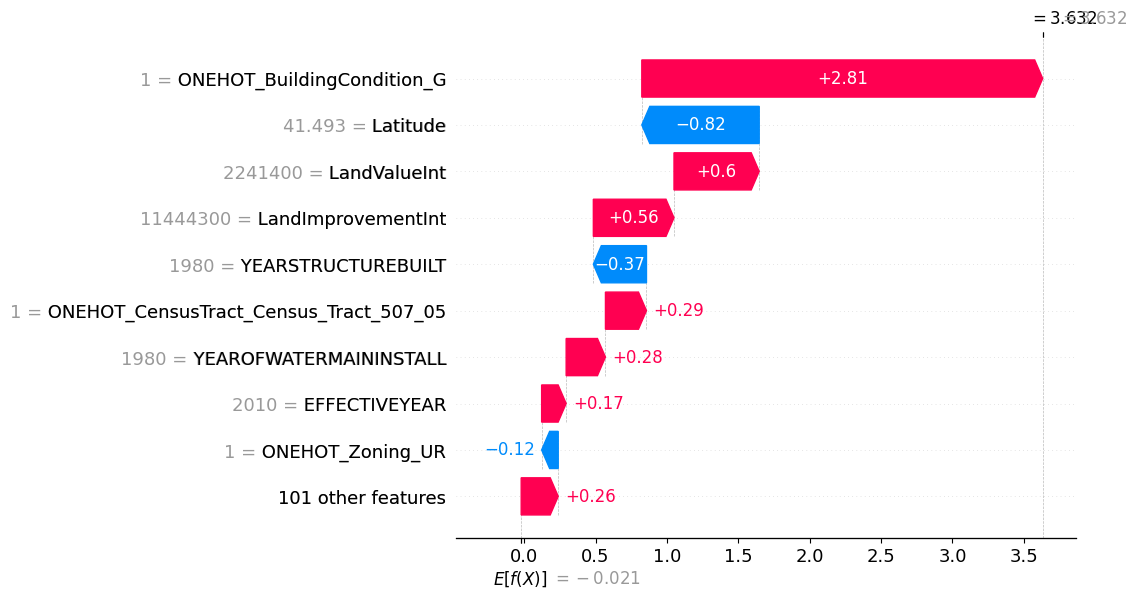

In [32]:
# waterfall plot
if data_point_index:
    # Get the row from X_pred that corresponds to the FacilityID
    data_point = X_pred.iloc[data_point_index[0]]

    # Create a SHAP explainer
    explainer = shap.Explainer(final_model)

    # Calculate SHAP values for the selected data point
    shap_values = explainer([data_point])

    # Display the SHAP waterfall plot for the specific data point
    shap.plots.waterfall(shap_values[0])

In [33]:
shap.plots.force(shap_values[0])

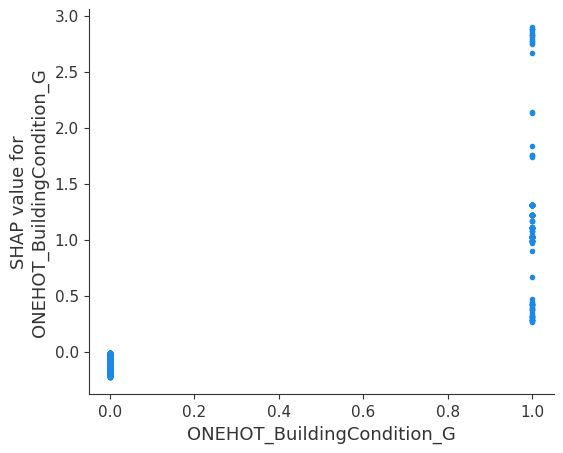

In [34]:
# Feature name to plot 
feature_name = "ONEHOT_BuildingCondition_G"

# Check if the feature exists in the data
if feature_name in X_pred.columns:
    # Generate SHAP values for the entire prediction dataset (or subset if necessary)
    shap_values = explainer(X_pred)

    # Create SHAP dependence plot for the selected feature
    shap.dependence_plot(feature_name, shap_values.values, X_pred, interaction_index=None)
else:
    print(f"Feature '{feature_name}' not found in the dataset. Please check the feature name.")

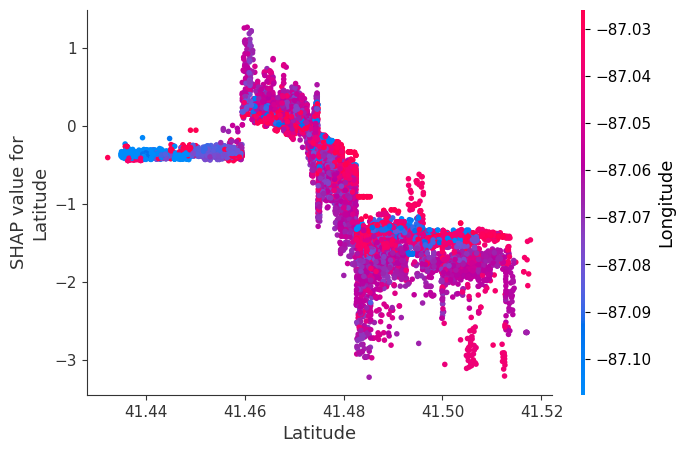

In [35]:
# Generate SHAP values for the entire dataset
shap_values = explainer(X_pred)

# Create a SHAP dependence plot for 'Latitude', coloring by 'Longitude'
shap.dependence_plot('Latitude', shap_values.values, X_pred, interaction_index='Longitude')